In [7]:
import seaborn as sns

In [4]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes(as_frame=True)
X, y = diabetes.data, diabetes.target
df=diabetes.frame

1. standardarize

In [ ]:
from  sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#### variance selector:
features with little variance

In [ ]:
X=X.drop(columns=['s2'])

<AxesSubplot:>

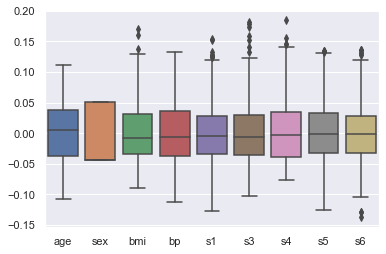

In [ ]:
sns.set(style="darkgrid")
sns.boxplot(data=X)

2. correlation

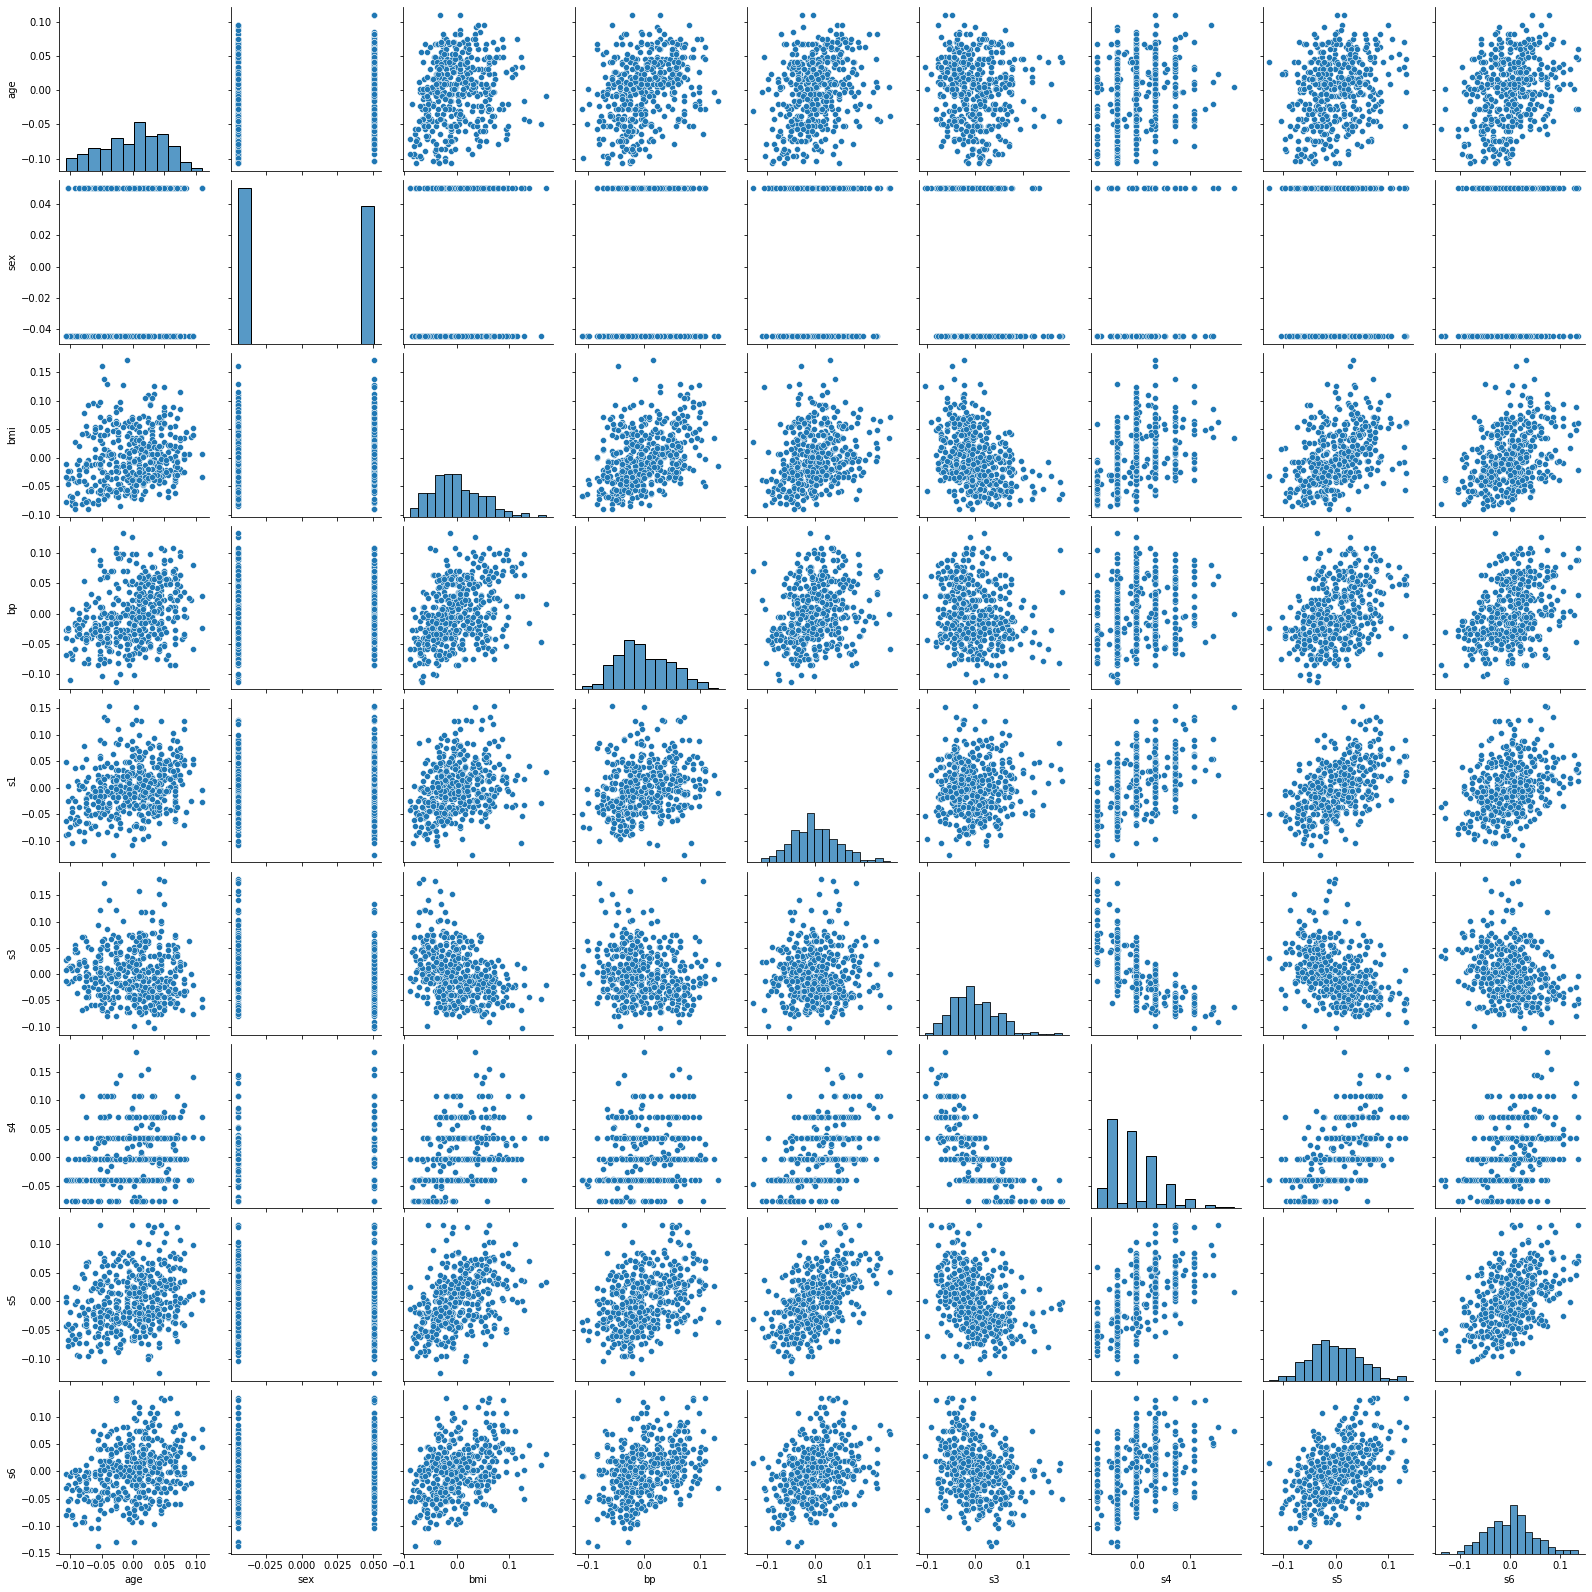

In [13]:
sns.pairplot(X, diag_kind='hist')

In [23]:
X.corr()

,age,sex,bmi,bp,s1,s3,s4,s5,s6
age,1.000000,0.173737,0.185085,0.335427,0.260061,-0.075181,0.203841,0.270777,0.301731
sex,0.173737,1.000000,0.088161,0.241013,0.035277,-0.379090,0.332115,0.149918,0.208133
bmi,0.185085,0.088161,1.000000,0.395415,0.249777,-0.366811,0.413807,0.446159,0.388680
bp,0.335427,0.241013,0.395415,1.000000,0.242470,-0.178761,0.257653,0.393478,0.390429
s1,0.260061,0.035277,0.249777,0.242470,1.000000,0.051519,0.542207,0.515501,0.325717
s3,-0.075181,-0.379090,-0.366811,-0.178761,0.051519,1.000000,-0.738493,-0.398577,-0.273697
s4,0.203841,0.332115,0.413807,0.257653,0.542207,-0.738493,1.000000,0.617857,0.417212
s5,0.270777,0.149918,0.446159,0.393478,0.515501,-0.398577,0.617857,1.000000,0.464670
s6,0.301731,0.208133,0.388680,0.390429,0.325717,-0.273697,0.417212,0.464670,1.000000


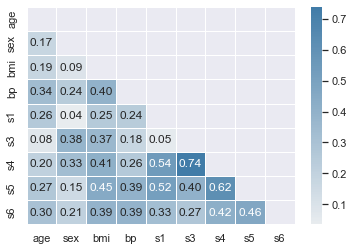

In [26]:
# Visualizing the correlation matrix
corr = X.corr().abs()
# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)
# Add the mask to the heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

C:\Users\zhe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<AxesSubplot:>

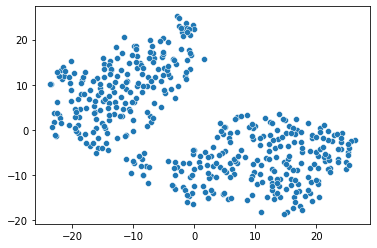

In [16]:
from sklearn.manifold import TSNE
m = TSNE(learning_rate=50).fit_transform(X)
sns.scatterplot(x=m[:,0], y=m[:,1])


### Select for better model accuracy

#### Recursive Feature Elimination

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE 
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=2, verbose=1)
rfe.fit(X,y)

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.


RFE(estimator=LogisticRegression(), n_features_to_select=2, verbose=1)

In [30]:
print(dict(zip(X.columns, rfe.ranking_)))
print(X.columns[rfe.support_])

{'age': 5, 'sex': 7, 'bmi': 1, 'bp': 3, 's1': 8, 's3': 2, 's4': 4, 's5': 1, 's6': 6}
Index(['bmi', 's5'], dtype='object')


#### lasso

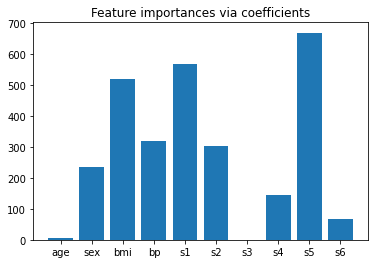

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
feature_names = np.array(diabetes.feature_names)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

### feature selection ensemble

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
from sklearn.linear_model import LassoCV
# Create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_train, y_train)
print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))
# Calculate R squared on the test set
r_squared = lcv.score(X_test,y_test)
print('The model explains {0:.1%} of the test set variance'.format(r_squared))
# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_!=0
print('{} features out of {} selected'.format(sum(lcv_mask), len(lcv_mask)))

Optimal alpha = 0.058
The model explains 51.1% of the test set variance
7 features out of 9 selected


In [37]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
# Select 10 features with RFE on a RandomForestRegressor, drop 3 features on each step
rfe_rf = RFE(estimator=RandomForestRegressor(), 
             n_features_to_select=7, step=3, verbose=1)
rfe_rf.fit(X_train, y_train)
# Calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))
# Assign the support array to gb_mask
rf_mask = rfe_rf.support_

Fitting estimator with 9 features.
The model can explain 42.8% of the variance in the test set


In [36]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=7, step=3, verbose=1)
rfe_gb.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
gb_mask = rfe_gb.support_

Fitting estimator with 9 features.
The model can explain 40.1% of the variance in the test set


In [39]:
# Sum the votes of the three models
votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)
# Create a mask for features selected by all 3 models
meta_mask = votes >= 3
# Apply the dimensionality reduction on X
X_reduced = X.loc[:, meta_mask]

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
lm= LinearRegression()
lm.fit(scaler.fit_transform(X_train), y_train)
r_squared = lm.score(scaler.transform(X_test), y_test)
print('The model can explain {0:.1%} of the variance in the test set using {1:} features.'.format(r_squared, len(lm.coef_)))

The model can explain 50.6% of the variance in the test set using 9 features.


based on initial lasso selection, 'bmi' and 's5' are the two most important factors.

In [50]:
from sklearn.linear_model import LinearRegression

lm= LinearRegression()
lm.fit(X_train[['bmi','s5']], y_train)
r_squared = lm.score(X_test[['bmi','s5']], y_test)
print('The model can explain {0:.1%} of the variance in the test set using {1:} features.'.format(r_squared, len(lm.coef_)))

The model can explain 50.3% of the variance in the test set using 2 features.


PCA pipeline

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
pipe = Pipeline([ ('scaler', StandardScaler()), ('reducer', PCA(n_components=3)), ('classifier', RandomForestRegressor())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.46867465545074005